<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Анализ моделей</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект: Обнаружение негативных комментариев

## Подготовка

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from tqdm.notebook import tqdm
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle

In [1]:
#df = pd.read_csv('###')

<b>Загрузим лемматизатор из NLTK и предобученный POS теггер</b>

In [4]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

<b>Сформируем словарь с POS тегами</b>

In [5]:
tag_map = defaultdict(lambda : wordnet.NOUN)
tag_map['J'] = wordnet.ADJ
tag_map['V'] = wordnet.VERB
tag_map['R'] = wordnet.ADV

<b>Скачаем стопслова, сформируем множество стопслов и определим progressbar для pandas операций</b>

In [6]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
tqdm.pandas()

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [7]:
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<b>Напишем функции для предварительной очистки текста от лишних знаков и цифр</b>

In [8]:
def clear_text(text):
    """Функция очистки текста от лишних знаков и цифр"""
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return " ".join(text.split())


def main_lemm(clm : pd.Series):
    """Функция лемматизации корпуса, с учётом POS тегов"""
    temp_list = []
    m = WordNetLemmatizer()
    for col in tqdm(clm):
        lemma = [m.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(word_tokenize(col))]
        temp_list.append(" ".join(lemma))
    return temp_list

<b>Применим функцию очистки для корпуса из dataset'а</b>

In [9]:
df['clean_text'] = df['text'].progress_apply(lambda x: clear_text(x))

<b>Лемматизируем очищенный корпус текстов</b>

In [10]:
df['lemm_text'] = main_lemm(df['clean_text'])

<b>Отобразим графически количество классов в датасете</b>

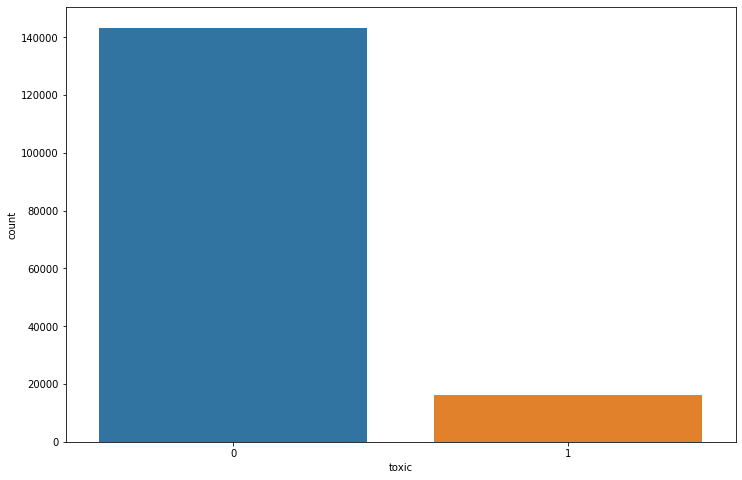

In [11]:
plt.figure(figsize=(12, 8))
sns.countplot(df['toxic'])
plt.show()

<b>Вывод: У нас явный дисбаланс классов</b>

<b>Разобъём датасет на тестовый и тренировочный, в пропорции 25/75</b>

In [14]:
df_train, df_test = train_test_split(df[['lemm_text', 'toxic']],
                                                    test_size=0.25,
                                                    random_state=0,
                                                    stratify=df['toxic'])

<b>Переведём корпуса тренировочной и тестовой выборки в удобный для венторизации вид</b>

In [ ]:
corpus = df_train['lemm_text'].values.astype('U')
test_corpus = df_test['lemm_text'].values.astype('U')

<b>Векторизуем корпуса</b>

In [12]:
count_vect = TfidfVectorizer(stop_words=stopwords, max_features=10000, min_df=5)
tf_idf_train = count_vect.fit_transform(corpus)
tf_idf_test = count_vect.transform(test_corpus)

In [14]:
display(tf_idf_train.shape, tf_idf_test.shape)

(119678, 25544)

(39893, 25544)

## Обучение

<b>Обучим ряд моделей, чтобы выявить лучшую метрику на кросс валидации</b>

<b>LogisticRegression</b>

In [15]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [4]:
#%%time
#lr_model = LogisticRegression(solver='liblinear', random_state=17)
#lr_cvs = cross_val_score(lr_model, tf_idf_train, df_train['toxic'], scoring='f1', 
#                         n_jobs=-1, verbose=1, cv=skf)
#print(lr_cvs, lr_cvs.mean())

[0.71673052 0.73023839 0.73655514 0.728      0.72690964] 0.7276867391308537

Wall time: 4.1 s

<b>SVC model</b>

In [17]:
#%%time
#svc_model = SVC(random_state=444) #, gamma='auto', probability=True)
#svc_cvs = cross_val_score(svc_model, tf_idf_train, df_train['toxic'], scoring='f1', 
#                          n_jobs=-1, verbose=1,  cv=skf)
#print(svc_cvs, svc_cvs.mean())

[0.73810716 0.74281467 0.74526212 0.74908201 0.74809909] 0.7446730100256298

Wall time: 31min 52s

<b>SGDClassifier</b>

In [18]:
#%%time
#np.random.seed(555)
#sgd_model = SGDClassifier()
#sgd_cvs = cross_val_score(sgd_model, tf_idf_train, df_train['toxic'], scoring='f1', 
#                            n_jobs=-1, verbose=1,  cv=skf)
#print(sgd_cvs, sgd_cvs.mean())

[0.63825076 0.64841183 0.64770241 0.63971397 0.65099754] 0.6450153017971872

Wall time: 2.73 s

<b>KNeighborsClassifier Model</b>

In [19]:
#%%time
#np.random.seed(666)
#knn_model = KNeighborsClassifier()
#knn_cvs = cross_val_score(knn_model, tf_idf_train, df_train['toxic'], scoring='f1', 
#                            n_jobs=-1, verbose=1,  cv=skf)
#print(knn_cvs, knn_cvs.mean())

[0.31786942 0.30222222 0.32633887 0.31958128 0.31542461] 0.31628727902798365

Wall time: 11min 45s

<b>DummyClassifier model</b>

In [20]:
#%%time
#dum_model = DummyClassifier(random_state=888)
#dum_cvs = cross_val_score(dum_model, tf_idf_train, df_train['toxic'], scoring='f1', 
#                            n_jobs=-1, verbose=1,  cv=skf)
#print(dum_cvs, dum_cvs.mean())

[0.10291734 0.10656402 0.10777958 0.08752026 0.09805511] 0.1005672609400324

Wall time: 2.43 s

<b>LGBMClassifier</b>

In [21]:
#%%time
#np.random.seed(999)
#lgbm_model = LGBMClassifier()
#lgbm_cvs = cross_val_score(lgbm_model, tf_idf_train, df_train['toxic'], scoring='f1', 
#                            n_jobs=-1, verbose=1,  cv=skf)
#print(lgbm_cvs, lgbm_cvs.mean())

[0.73973949 0.739971   0.7515006  0.75017895 0.74674385] 0.7456267797706755

Wall time: 1min 2s

<b>XGBClassifier</b>

In [22]:
#%%time
#np.random.seed(998)
#xgb_model = XGBClassifier()
#xgb_cvs = cross_val_score(xgb_model, tf_idf_train, df_train['toxic'], scoring='f1', 
#                            n_jobs=-1, verbose=1,  cv=skf)
#print(xgb_cvs, xgb_cvs.mean())

[0.72176309 0.72372001 0.72053705 0.73127753 0.72547076] 0.7245536875420405

Wall time: 2min 16s

<b>GradientBoostingClassifier</b>

In [23]:
#%%time
#np.random.seed(997)
#grad_model = GradientBoostingClassifier()
#grad_cvs = cross_val_score(grad_model, tf_idf_train, df_train['toxic'], scoring='f1', 
#                            n_jobs=-1, verbose=1,  cv=skf)
#print(grad_cvs, grad_cvs.mean())

[0.59473237 0.61319967 0.5927806  0.60661662 0.59796725] 0.6010593018455402

Wall time: 2min 20s

### Анализ моделей

<b>Таблица производительности и качества моделей</b>

| Model | Execution time | F1_Score |
| --- | --- | --- |
| LGBMClassifier | 1min 2s | 0.745 |
| SVC | 31min 52s | 0.744 |
| LogisticRegression | 4.1 s | 0.727 |
| XGBClassifier | 2min 16s | 0.724 |
| SGDClassifier | 2.73 s | 0.645 |
| GradientBoostingClassifier | 2min 20s | 0.601 |
| KNeighborsClassifier | 11min 45s | 0.316 |
| DummyClassifier | 2.43 s | 0.100 |

LGBMClassifier и LogisticRegression - главные претенденты

In [1]:
#%%time
#grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
#logreg=LogisticRegression(random_state=765, solver='liblinear', class_weight='balanced')
#logreg_cv=GridSearchCV(logreg,grid,cv=skf, scoring='f1', verbose=1, n_jobs=-1)
#logreg_cv.fit(tf_idf_train, df_train['toxic'])
#print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
#print("f1 :", logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}

accuracy : 0.7439368911660623

Wall time: 5min 42s

<b>LGBMClassifier</b>

In [25]:
#%%time
#params = {'num_leaves': [10, 12, 14, 16],
#          'max_depth': [4, 5, 6, 8, 10],
#          'n_estimators': [50, 60, 70, 80],
#          'is_unbalance': [True]} 
#
#lgb_estimator = LGBMClassifier(random_state=764)
#gsearch = GridSearchCV(lgb_estimator, params, cv=skf, scoring='f1', n_jobs=-1, verbose=1, )
#lgb_model = gsearch.fit(tf_idf_train, df_train['toxic'])
#
#print(lgb_model.best_params_, lgb_model.best_score_)

{'is_unbalance': True, 'max_depth': 10, 'n_estimators': 80, 'num_leaves': 16} 

0.720317530621158

Wall time: 30min 37s

<b>Финальная модель</b>

F1_Score: 0.768


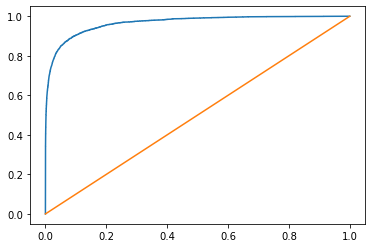

Wall time: 2.46 s


In [32]:
%%time
lr_final = LogisticRegression(solver='liblinear', C=10, penalty='l2', random_state=17)
lr_final.fit(tf_idf_train, df_train['toxic'])
predicted_lr = lr_final.predict(tf_idf_test)
lr_proba = lr_final.predict_proba(tf_idf_test)
lr_one_test = lr_proba[:, 1]
lr_auc = roc_auc_score(df_test['toxic'], lr_one_test)
print("F1_Score: {:.3f}".format(f1_score(df_test['toxic'], predicted_lr)))
fpr, tpr, thresholds = roc_curve(df_test['toxic'], lr_one_test)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.show()

## Выводы

* В этом проекте использовал pipeline обработки текста через TF-IDF Vectorizer
* Были кросс-валидированы ряд моделей, среди которых выиграла LogisticRegression по метрике и времени выполнения
* Финальная модель показала F1_Score: 0.768 на тестовой выборке(получается впритык к пороговой оценке)